# Importing necessary library

In [1]:
import sys
sys.path.insert(0, '../src')
from terminal_script import read_data
from terminal_script import plot_top_10_by_state
from terminal_script import two_sample_t_test
from terminal_script import t_test_against_others
from terminal_script import t_test_weather_quan
from terminal_script import t_test_weather_city
from terminal_script import airline_t_test
import importlib
importlib.reload(sys.modules['terminal_script'])

<module 'terminal_script' from '../src/terminal_script.py'>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Rolling 12-months data

In [3]:
df_02 = read_data('../data/2019_02_ALL.csv')
df_03 = read_data('../data/2019_03_ALL.csv')
df_04 = read_data('../data/2019_04_ALL.csv')
df_05 = read_data('../data/2019_05_ALL.csv')
df_06 = read_data('../data/2019_06_ALL.csv')
df_07 = read_data('../data/2019_07_ALL.csv')
df_08 = read_data('../data/2019_08_ALL.csv')
df_09 = read_data('../data/2019_09_ALL.csv')
df_10 = read_data('../data/2019_10_ALL.csv')
df_11 = read_data('../data/2019_11_ALL.csv')
df_12 = read_data('../data/2019_12_ALL.csv')
df_01 = read_data('../data/2020_01_ALL.csv')

In [4]:
frames = [df_02,df_03,df_04,df_05,df_06,df_07,df_08,df_09,df_10,df_11,df_12,df_01]

In [5]:
df_one_year = pd.concat(frames)

# Integrating Weather Data

In [7]:
df_weather = pd.read_csv('../data/19_02_20_01_SFO_DAILY.csv', usecols=['DATE','AWND','PRCP','TAVG','WT01','WT02','WT03','WT08'], parse_dates=['DATE'])

In [8]:
df_weather.columns = ["date", "avg_wind_spd", "precip", "avg_temp", "fog", "heavy_fog", "thunder", "smoke_haze"]

In [9]:
df_weather.fillna(value=0, inplace=True)

In [10]:
df_weather.head(5)

date  avg_wind_spd  precip  avg_temp  fog  heavy_fog  thunder  \
0 2019-02-01           4.4     3.3      12.9  0.0        0.0      0.0   
1 2019-02-02           8.2    17.3      12.6  1.0        0.0      0.0   
2 2019-02-03           6.0     3.6      11.4  1.0        0.0      0.0   
3 2019-02-04           7.3    15.7      10.5  1.0        0.0      0.0   
4 2019-02-05           4.3     2.5       7.0  0.0        0.0      0.0   

   smoke_haze  
0         0.0  
1         0.0  
2         1.0  
3         1.0  
4         1.0

In [11]:
df_sfo = df_one_year[df_one_year['ORIGIN_CITY_NAME'] == "San Francisco, CA"]

In [12]:
df_sfo_pivot = df_sfo.groupby(['ORIGIN_CITY_NAME','FL_DATE']).agg(
    total_flight=pd.NamedAgg(column='DEP_DELAY',aggfunc='count'),
    avg_delay_min=pd.NamedAgg(column='DEP_DELAY',aggfunc='mean'),
    cancelled_count=pd.NamedAgg(column='CANCELLED',aggfunc='sum'),
)
df_sfo_pivot = df_sfo_pivot.reset_index()
df_sfo_pivot['FL_DATE'] = pd.to_datetime(df_sfo_pivot['FL_DATE'])

In [70]:
df_sfo_pivot.sample(5)

ORIGIN_CITY_NAME    FL_DATE  total_flight  avg_delay_min  \
176  San Francisco, CA 2019-07-27           451       6.771619   
54   San Francisco, CA 2019-03-27           455      36.167033   
18   San Francisco, CA 2019-02-19           430       0.427907   
210  San Francisco, CA 2019-08-30           552      11.831522   
339  San Francisco, CA 2020-01-06           452       3.402655   

     cancelled_count  
176              2.0  
54              18.0  
18               9.0  
210              6.0  
339              5.0

In [13]:
df_combined = df_sfo_pivot.join(df_weather.set_index('date'),on='FL_DATE')

In [78]:
df_combined.head(5)

ORIGIN_CITY_NAME    FL_DATE  total_flight  avg_delay_min  cancelled_count  \
0  San Francisco, CA 2019-02-01           417      26.160671             43.0   
1  San Francisco, CA 2019-02-02           329      21.705167             29.0   
2  San Francisco, CA 2019-02-03           413      11.636804              6.0   
3  San Francisco, CA 2019-02-04           447      24.861298             15.0   
4  San Francisco, CA 2019-02-05           422       2.943128              6.0   

   avg_wind_spd  precip  avg_temp  fog  heavy_fog  thunder  smoke_haze  
0           4.4     3.3      12.9  0.0        0.0      0.0         0.0  
1           8.2    17.3      12.6  1.0        0.0      0.0         0.0  
2           6.0     3.6      11.4  1.0        0.0      0.0         1.0  
3           7.3    15.7      10.5  1.0        0.0      0.0         1.0  
4           4.3     2.5       7.0  0.0        0.0      0.0         1.0

In [14]:
df_combined['cancel_rate'] = df_combined['cancelled_count'] / df_combined['total_flight']

In [81]:
df_combined.corr()

total_flight  avg_delay_min  cancelled_count  avg_wind_spd  \
total_flight         1.000000      -0.168144        -0.352158      0.045596   
avg_delay_min       -0.168144       1.000000         0.751466      0.191894   
cancelled_count     -0.352158       0.751466         1.000000      0.259371   
avg_wind_spd         0.045596       0.191894         0.259371      1.000000   
precip              -0.321585       0.518425         0.498733      0.137547   
avg_temp             0.404968      -0.088188        -0.035567      0.193203   
fog                 -0.216687       0.225791         0.158836     -0.073424   
heavy_fog           -0.041207       0.095659        -0.007201     -0.204712   
thunder             -0.078504       0.326277         0.248912      0.072925   
smoke_haze           0.090710       0.108300         0.017758     -0.001433   
cancel_rate         -0.393657       0.721251         0.994510      0.262323   

                   precip  avg_temp       fog  heavy_fog   thunder  \
total_flight    -0.321585  0.404968 -0.216687  -0.041207 -0.078504   
avg_delay_min    0.518425 -0.088188  0.225791   0.095659  0.326277   
cancelled_count  0.498733 -0.035567  0.158836  -0.007201  0.248912   
avg_wind_spd     0.137547  0.193203 -0.073424  -0.204712  0.072925   
precip           1.000000 -0.234537  0.344332  -0.042706  0.434745   
avg_temp        -0.234537  1.000000 -0.320325  -0.089624 -0.141233   
fog              0.344332 -0.320325  1.000000   0.179342  0.121372   
heavy_fog       -0.042706 -0.089624  0.179342   1.000000 -0.018077   
thunder          0.434745 -0.141233  0.121372  -0.018077  1.000000   
smoke_haze       0.160806 -0.207294  0.522553   0.086149  0.073459   
cancel_rate      0.505795 -0.042442  0.155368  -0.009204  0.250235   

                 smoke_haze  cancel_rate  
total_flight       0.090710    -0.393657  
avg_delay_min      0.108300     0.721251  
cancelled_count    0.017758     0.994510  
avg_wind_spd      -0.001433     0.262323  
precip             0.160806     0.505795  
avg_temp          -0.207294    -0.042442  
fog                0.522553     0.155368  
heavy_fog          0.086149    -0.009204  
thunder            0.073459     0.250235  
smoke_haze         1.000000     0.008648  
cancel_rate        0.008648     1.000000

Text(0.5, 0.9, 'SFO - Cancellation Rate & Qualitative Weather Conditions')

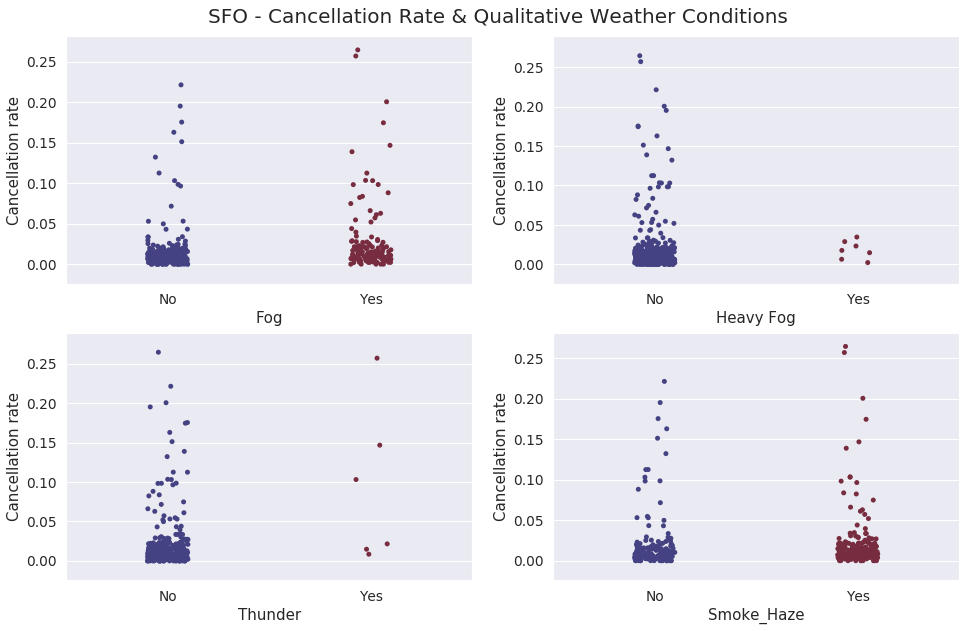

In [129]:
fig, axes = plt.subplots(2,2,figsize=(16,10))

sns.stripplot(x="fog",y="cancel_rate",data=df_combined,jitter=True,ax=axes[0, 0],palette='icefire')
sns.stripplot(x="heavy_fog",y="cancel_rate",data=df_combined,jitter=True,ax=axes[0, 1],palette='icefire')
sns.stripplot(x="thunder",y="cancel_rate",data=df_combined,jitter=True,ax=axes[1, 0],palette='icefire')
sns.stripplot(x="smoke_haze",y="cancel_rate",data=df_combined,jitter=True,ax=axes[1, 1],palette='icefire')

axes[0,0].set_xticklabels(['No', 'Yes'])
axes[0,0].set(xlabel="Fog",ylabel="Cancellation rate")
axes[0,1].set_xticklabels(['No', 'Yes'])
axes[0,1].set(xlabel="Heavy Fog",ylabel="Cancellation rate")
axes[1,0].set_xticklabels(['No', 'Yes'])
axes[1,0].set(xlabel="Thunder",ylabel="Cancellation rate")
axes[1,1].set_xticklabels(['No', 'Yes'])
axes[1,1].set(xlabel="Smoke_Haze",ylabel="Cancellation rate")
plt.figtext(.5,.90,'SFO - Cancellation Rate & Qualitative Weather Conditions', fontsize=20, ha='center')

# fig.savefig('img/qual_weather_cancel_corr.png')

Text(0.5, 0.9, 'SFO - Average Delay Time & Qualitative Weather Conditions')

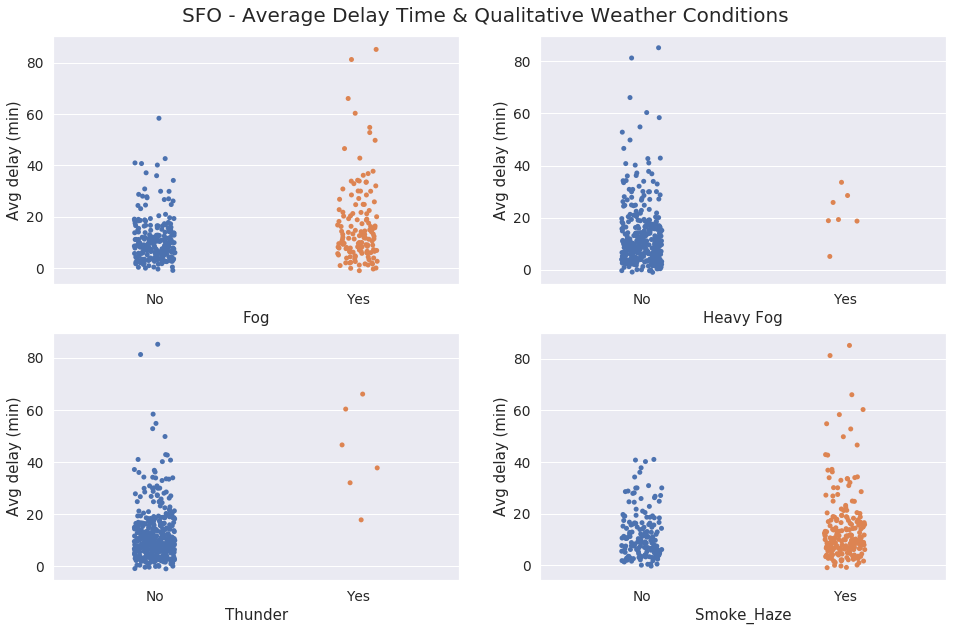

In [130]:
fig, axes = plt.subplots(2,2,figsize=(16,10))

sns.stripplot(x="fog",y="avg_delay_min",data=df_combined,jitter=True,ax=axes[0, 0])
sns.stripplot(x="heavy_fog",y="avg_delay_min",data=df_combined,jitter=True,ax=axes[0, 1])
sns.stripplot(x="thunder",y="avg_delay_min",data=df_combined,jitter=True,ax=axes[1, 0])
sns.stripplot(x="smoke_haze",y="avg_delay_min",data=df_combined,jitter=True,ax=axes[1, 1])

axes[0,0].set_xticklabels(['No', 'Yes'])
axes[0,0].set(xlabel="Fog",ylabel="Avg delay (min)")
axes[0,1].set_xticklabels(['No', 'Yes'])
axes[0,1].set(xlabel="Heavy Fog",ylabel="Avg delay (min)")
axes[1,0].set_xticklabels(['No', 'Yes'])
axes[1,0].set(xlabel="Thunder",ylabel="Avg delay (min)")
axes[1,1].set_xticklabels(['No', 'Yes'])
axes[1,1].set(xlabel="Smoke_Haze",ylabel="Avg delay (min)")
plt.figtext(.5,.90,'SFO - Average Delay Time & Qualitative Weather Conditions', fontsize=20, ha='center')

# fig.savefig('img/qual_weather_avg_delay_corr.png')

Text(0.8, 0.3, 'r=0.51')

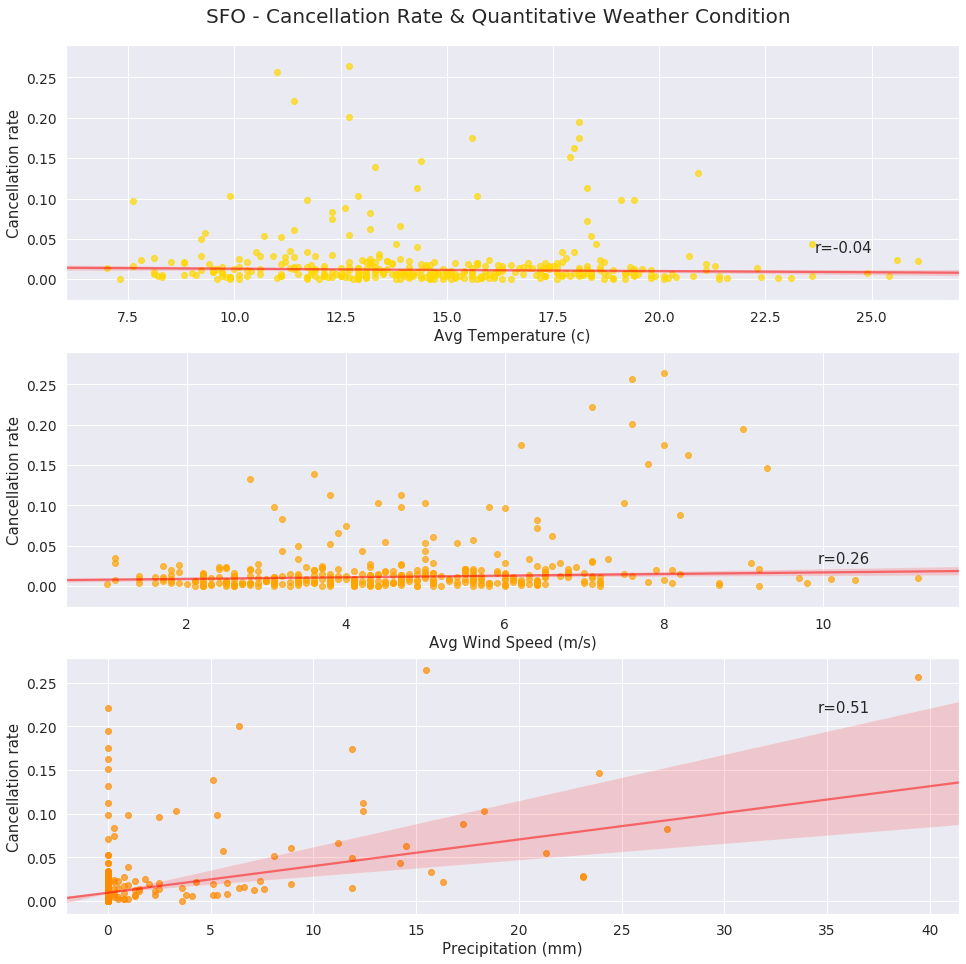

In [133]:
fig, axes = plt.subplots(3,1,figsize=(16,16))

sns.regplot(x='avg_temp',y='cancel_rate',data=df_combined,robust=True, scatter_kws = {'color': 'gold', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[0])
sns.regplot(x='avg_wind_spd',y='cancel_rate',data=df_combined,robust=True, scatter_kws = {'color': 'orange', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[1])
sns.regplot(x='precip',y='cancel_rate',data=df_combined,robust=True, scatter_kws = {'color': 'darkorange', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[2])

axes[0].set(xlabel="Avg Temperature (c)",ylabel="Cancellation rate")
axes[1].set(xlabel="Avg Wind Speed (m/s)",ylabel="Cancellation rate")
axes[2].set(xlabel="Precipitation (mm)",ylabel="Cancellation rate")

plt.figtext(.5,.9,'SFO - Cancellation Rate & Quantitative Weather Condition', fontsize=20, ha='center')
plt.figtext(.8,.7,'r=-0.04', fontsize=15, ha='center')
plt.figtext(.8,.43,'r=0.26', fontsize=15, ha='center')
plt.figtext(.8,.3,'r=0.51', fontsize=15, ha='center')

# fig.savefig('img/quan_weather_cancel_corr.png')

Text(0.8, 0.32, 'r=.52')

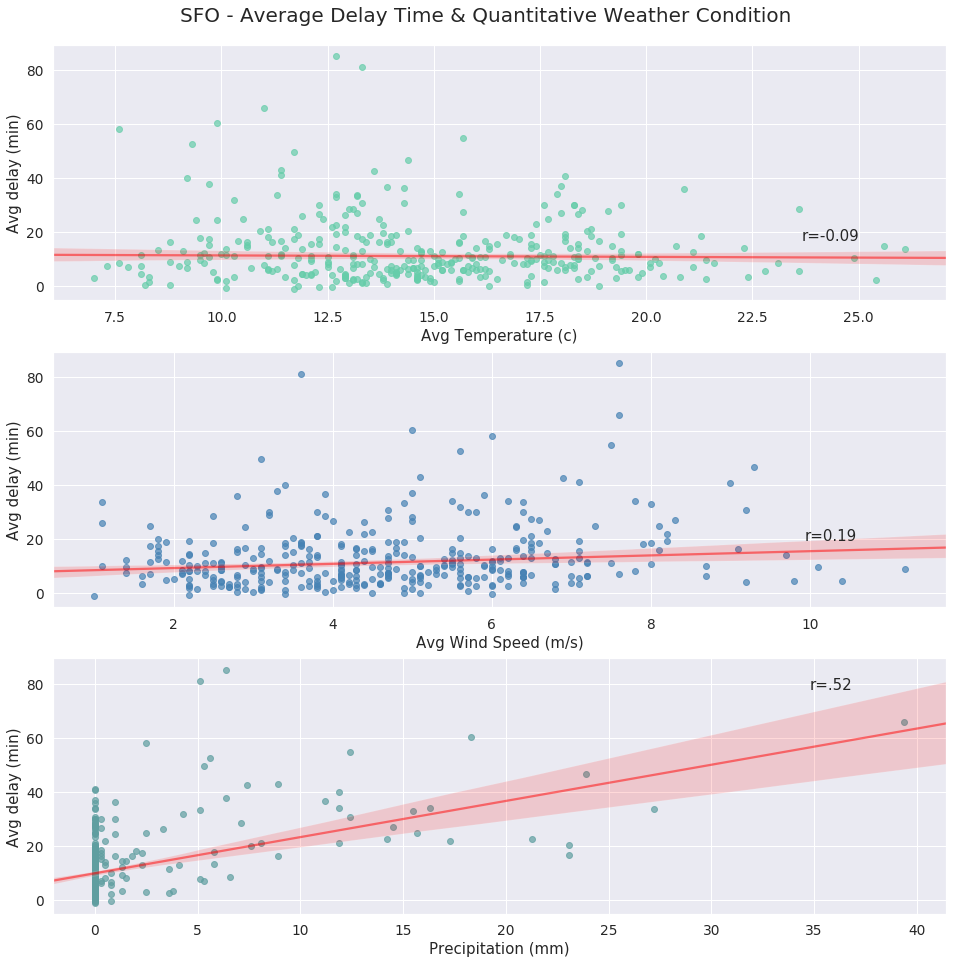

In [134]:
fig, axes = plt.subplots(3,1,figsize=(16,16))

sns.regplot(x='avg_temp',y='avg_delay_min',data=df_combined,robust=True, scatter_kws = {'color': 'mediumaquamarine', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[0])
sns.regplot(x='avg_wind_spd',y='avg_delay_min',data=df_combined,robust=True, scatter_kws = {'color': 'steelblue', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[1])
sns.regplot(x='precip',y='avg_delay_min',data=df_combined,robust=True, scatter_kws = {'color': 'cadetblue', 'alpha': 0.7}, line_kws = {'color': 'red', 'alpha':0.5},ax=axes[2])

axes[0].set(xlabel="Avg Temperature (c)",ylabel="Avg delay (min)")
axes[1].set(xlabel="Avg Wind Speed (m/s)",ylabel="Avg delay (min)")
axes[2].set(xlabel="Precipitation (mm)",ylabel="Avg delay (min)")

plt.figtext(.5,.9,'SFO - Average Delay Time & Quantitative Weather Condition', fontsize=20, ha='center')
plt.figtext(.8,.71,'r=-0.09', fontsize=15, ha='center')
plt.figtext(.8,.45,'r=0.19', fontsize=15, ha='center')
plt.figtext(.8,.32,'r=.52', fontsize=15, ha='center')

# fig.savefig('img/quan_weather_avg_delay_corr.png')

#### t-test - fog focus

In [33]:
a = df_combined[df_combined['fog'] == 1]['avg_delay_min']
b = df_combined[df_combined['fog'] == 0]['avg_delay_min']
t_stat, p_val = scs.ttest_ind(a,b,equal_var=False)
print(t_stat,p_val)

3.9133026678308456 0.00012580596426529727


In [35]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(df_combined,'fog','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 227
16.67798694165874 11.102852222334388
1.4246622846616341
3.9133026678308407 6.290298213264961e-05


In [36]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(df_combined,'fog','cancel_rate')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 227
0.028051475714197926 0.016262655040825604
0.00428600905834753
2.750535641172326 0.0032251920146964186


In [37]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(df_combined,'smoke_haze','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

201 164
14.381992181107 11.77517819522138
1.2065631572323254
2.160528415160014 0.015706469058247283


In [38]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(df_combined,'smoke_haze','cancel_rate')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

201 164
0.02100719768555948 0.02036755858554433
0.003879003183115095
0.16489780230122872 0.4345598747195719


# More Weather

In [6]:
sfo_weather = pd.read_csv('../data/19_02_20_01_SFO_DAILY.csv', usecols=['NAME','DATE','AWND','PRCP','TAVG','WT01','WT02','WT03','WT08'], parse_dates=['DATE'])
other_ca_weather = pd.read_csv('../data/19_02_20_01_LA_OAK_SJ_SD_DAILY.csv', usecols=['NAME','DATE','AWND','PRCP','TAVG','WT01','WT02','WT03','WT08'], parse_dates=['DATE'])

In [10]:
sfo_weather.head()

NAME       DATE  AWND  PRCP  TAVG  \
0  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-01   4.4   3.3  12.9   
1  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-02   8.2  17.3  12.6   
2  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-03   6.0   3.6  11.4   
3  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-04   7.3  15.7  10.5   
4  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-05   4.3   2.5   7.0   

   WT01  WT02  WT03  WT08  
0   NaN   NaN   NaN   NaN  
1   1.0   NaN   NaN   NaN  
2   1.0   NaN   NaN   1.0  
3   1.0   NaN   NaN   1.0  
4   NaN   NaN   NaN   1.0

In [11]:
other_ca_weather.head()

NAME       DATE   AWND  PRCP  TAVG  WT01  WT02  \
0  OAKLAND METROPOLITAN, CA US 2019-02-01  13.42  0.14   NaN   NaN   NaN   
1  OAKLAND METROPOLITAN, CA US 2019-02-02  21.03  0.44   NaN   1.0   NaN   
2  OAKLAND METROPOLITAN, CA US 2019-02-03  15.21  0.04   NaN   1.0   NaN   
3  OAKLAND METROPOLITAN, CA US 2019-02-04  18.12  0.54   NaN   1.0   NaN   
4  OAKLAND METROPOLITAN, CA US 2019-02-05   7.16  0.10   NaN   NaN   NaN   

   WT03  WT08  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   1.0  
3   1.0   1.0  
4   NaN   NaN

In [8]:
ca_five_weather_df = sfo_weather.append(other_ca_weather)

In [9]:
ca_five_weather_df.columns = ["city","date", "avg_wind_spd", "precip", "avg_temp", "fog", "heavy_fog", "thunder", "smoke_haze"]

In [15]:
ca_five_weather_df.head()

city       date  avg_wind_spd  \
0  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-01           4.4   
1  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-02           8.2   
2  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-03           6.0   
3  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-04           7.3   
4  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US 2019-02-05           4.3   

   precip  avg_temp  fog  heavy_fog  thunder  smoke_haze  
0     3.3      12.9  NaN        NaN      NaN         NaN  
1    17.3      12.6  1.0        NaN      NaN         NaN  
2     3.6      11.4  1.0        NaN      NaN         1.0  
3    15.7      10.5  1.0        NaN      NaN         1.0  
4     2.5       7.0  NaN        NaN      NaN         1.0

In [10]:
ca_five_weather_df.fillna(value=0, inplace=True)

In [17]:
ca_five_weather_df['city'].unique()

array(['SAN FRANCISCO INTERNATIONAL AIRPORT, CA US',
       'OAKLAND METROPOLITAN, CA US',
       'LOS ANGELES INTERNATIONAL AIRPORT, CA US',
       'SAN DIEGO INTERNATIONAL AIRPORT, CA US', 'SAN JOSE, CA US'],
      dtype=object)

In [11]:
ca_five_weather_dict = {'LOS ANGELES INTERNATIONAL AIRPORT, CA US':'Los Angeles, CA','OAKLAND METROPOLITAN, CA US':'Oakland, CA','SAN FRANCISCO INTERNATIONAL AIRPORT, CA US': 'San Francisco, CA','SAN DIEGO INTERNATIONAL AIRPORT, CA US': 'San Diego, CA','SAN JOSE, CA US': 'San Jose, CA'}
ca_five_weather_df.replace(to_replace={'city': ca_five_weather_dict}, inplace=True)
ca_five_weather_df.sample(5)

city       date  avg_wind_spd  precip  avg_temp  fog  \
160   San Francisco, CA 2019-07-11          6.80     0.0      17.7  0.0   
161         Oakland, CA 2019-07-12         10.07     0.0       0.0  0.0   
623     Los Angeles, CA 2019-10-18          7.83     0.0      67.0  0.0   
298   San Francisco, CA 2019-11-26          5.10    23.1      10.9  1.0   
1452       San Jose, CA 2020-01-25          4.03     0.0       0.0  1.0   

      heavy_fog  thunder  smoke_haze  
160         0.0      0.0         0.0  
161         0.0      0.0         0.0  
623         0.0      0.0         0.0  
298         0.0      0.0         1.0  
1452        0.0      0.0         1.0

In [12]:
ca_five_list = ['Los Angeles, CA','Oakland, CA','San Francisco, CA','San Diego, CA','San Jose, CA']
ca_five_filtered = df_one_year[df_one_year['ORIGIN_CITY_NAME'].isin(ca_five_list)]

In [13]:
ca_five_pivot = ca_five_filtered.groupby(['ORIGIN_CITY_NAME','FL_DATE']).agg(
    total_flight=pd.NamedAgg(column='DEP_DELAY',aggfunc='count'),
    avg_delay_min=pd.NamedAgg(column='DEP_DELAY',aggfunc='mean'),
    cancelled_count=pd.NamedAgg(column='CANCELLED',aggfunc='sum'),
).reset_index()
ca_five_pivot['FL_DATE'] = pd.to_datetime(ca_five_pivot['FL_DATE'])

In [14]:
ca_five_pivot['cancel_rate'] = ca_five_pivot['cancelled_count'] / ca_five_pivot['total_flight']

In [15]:
ca_five_flight_weather = pd.merge(ca_five_pivot,ca_five_weather_df,left_on=['ORIGIN_CITY_NAME','FL_DATE'],right_on=['city','date'],validate='1:1')

In [39]:
ca_five_flight_weather.sample(5)

ORIGIN_CITY_NAME    FL_DATE  total_flight  avg_delay_min  \
1630       San Jose, CA 2019-07-22           192       4.505208   
1624       San Jose, CA 2019-07-16           197       1.208122   
805       San Diego, CA 2019-04-18           264       7.348485   
1254  San Francisco, CA 2019-07-11           513      12.516569   
963       San Diego, CA 2019-09-23           266       5.462406   

      cancelled_count  cancel_rate               city       date  \
1630              5.0     0.026042       San Jose, CA 2019-07-22   
1624              0.0     0.000000       San Jose, CA 2019-07-16   
805               5.0     0.018939      San Diego, CA 2019-04-18   
1254             11.0     0.021442  San Francisco, CA 2019-07-11   
963               2.0     0.007519      San Diego, CA 2019-09-23   

      avg_wind_spd  precip  avg_temp  fog  heavy_fog  thunder  smoke_haze  
1630          6.04     0.0       0.0  0.0        0.0      0.0         0.0  
1624          6.93     0.0       0.0  0.0        0.0      0.0         0.0  
805           6.04     0.0      66.0  0.0        0.0      0.0         0.0  
1254          6.80     0.0      17.7  0.0        0.0      0.0         0.0  
963           4.47     0.0      72.0  0.0        0.0      0.0         0.0

In [16]:
ca_five_flight_weather_pivot = ca_five_flight_weather.groupby(['ORIGIN_CITY_NAME']).agg(
    total_flight_year = pd.NamedAgg(column='total_flight',aggfunc='sum'),
    fog_count = pd.NamedAgg(column='fog',aggfunc='sum'),
    heavy_fog_count = pd.NamedAgg(column='heavy_fog',aggfunc='sum'),
    thunder_count = pd.NamedAgg(column='thunder',aggfunc='sum'),
    smoke_haze_count = pd.NamedAgg(column='smoke_haze',aggfunc='sum'),
).reset_index()

In [51]:
ca_five_flight_weather_pivot

ORIGIN_CITY_NAME  total_flight_year  fog_count  heavy_fog_count  \
0    Los Angeles, CA             217173      114.0             15.0   
1        Oakland, CA              51845      132.0              9.0   
2      San Diego, CA              91995      126.0             10.0   
3  San Francisco, CA             167753      138.0              7.0   
4       San Jose, CA              61970       84.0              5.0   

   thunder_count  smoke_haze_count  
0            8.0             107.0  
1            4.0              77.0  
2            6.0              89.0  
3            6.0             201.0  
4            7.0              23.0

In [17]:
ca_five_flight_weather_pivot['fog_rate'] = ca_five_flight_weather_pivot['fog_count'] / 365
ca_five_flight_weather_pivot['heavy_fog_rate'] = ca_five_flight_weather_pivot['heavy_fog_count'] / 365
ca_five_flight_weather_pivot['thunder_rate'] = ca_five_flight_weather_pivot['thunder_count'] / 365
ca_five_flight_weather_pivot['smoke_haze_rate'] = ca_five_flight_weather_pivot['smoke_haze_count'] / 365

In [53]:
ca_five_flight_weather_pivot

ORIGIN_CITY_NAME  total_flight_year  fog_count  heavy_fog_count  \
0    Los Angeles, CA             217173      114.0             15.0   
1        Oakland, CA              51845      132.0              9.0   
2      San Diego, CA              91995      126.0             10.0   
3  San Francisco, CA             167753      138.0              7.0   
4       San Jose, CA              61970       84.0              5.0   

   thunder_count  smoke_haze_count  fog_rate  heavy_fog_rate  thunder_rate  \
0            8.0             107.0  0.312329        0.041096      0.021918   
1            4.0              77.0  0.361644        0.024658      0.010959   
2            6.0              89.0  0.345205        0.027397      0.016438   
3            6.0             201.0  0.378082        0.019178      0.016438   
4            7.0              23.0  0.230137        0.013699      0.019178   

   smoke_haze_rate  
0         0.293151  
1         0.210959  
2         0.243836  
3         0.550685  
4         0.063014

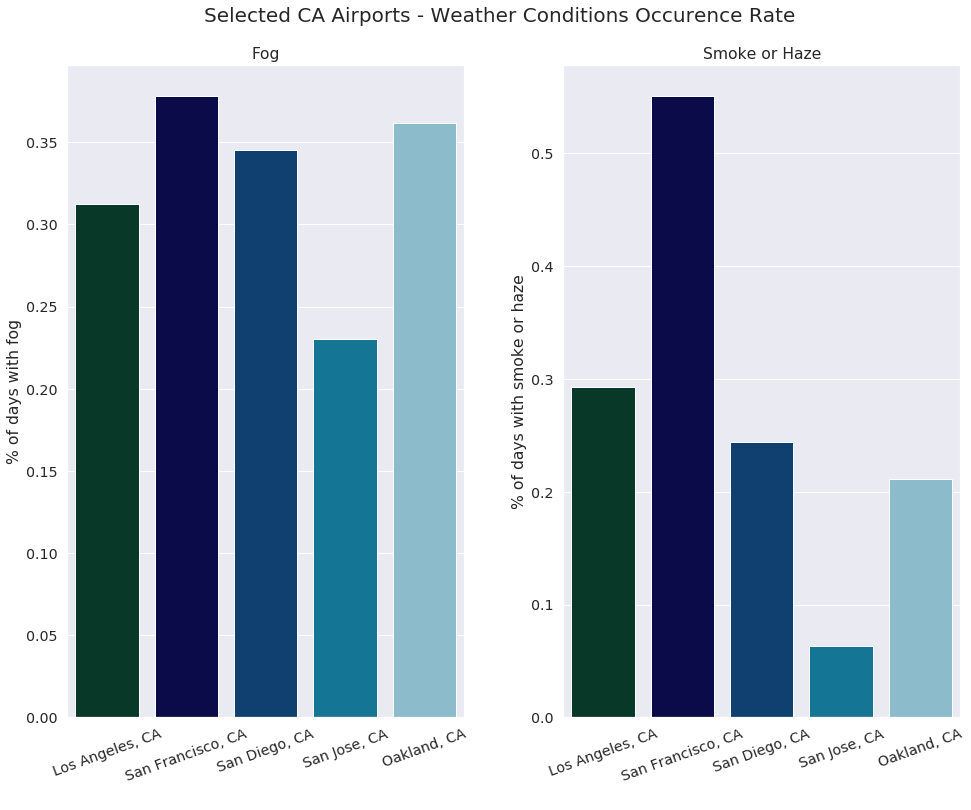

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,12))
sns.set(font_scale=1.3)

sns.barplot(x='ORIGIN_CITY_NAME',y='fog_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[0])
# sns.barplot(x='ORIGIN_CITY_NAME',y='heavy_fog_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[0,1])
# sns.barplot(x='ORIGIN_CITY_NAME',y='thunder_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[1,0])
sns.barplot(x='ORIGIN_CITY_NAME',y='smoke_haze_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[1])

axes[0].set(ylabel="% of days with fog")
axes[0].set_title('Fog')
# axes[0,1].set(ylabel="% of days with heavy fog")
# axes[0,1].set_title('Heavy Fog')
# axes[1,0].set(ylabel="% of days with thunder")
# axes[1,0].set_title('Thunder')
axes[1].set(ylabel="% of days with smoke or haze")
axes[1].set_title('Smoke or Haze')
for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')
plt.figtext(.5,.93,'Selected CA Airports - Weather Conditions Occurence Rate', fontsize=20, ha='center')
plt.subplots_adjust(wspace = 0.25, hspace = 0.3)
plt.savefig('../img/weather_CA_2.png', bbox_inches = "tight")

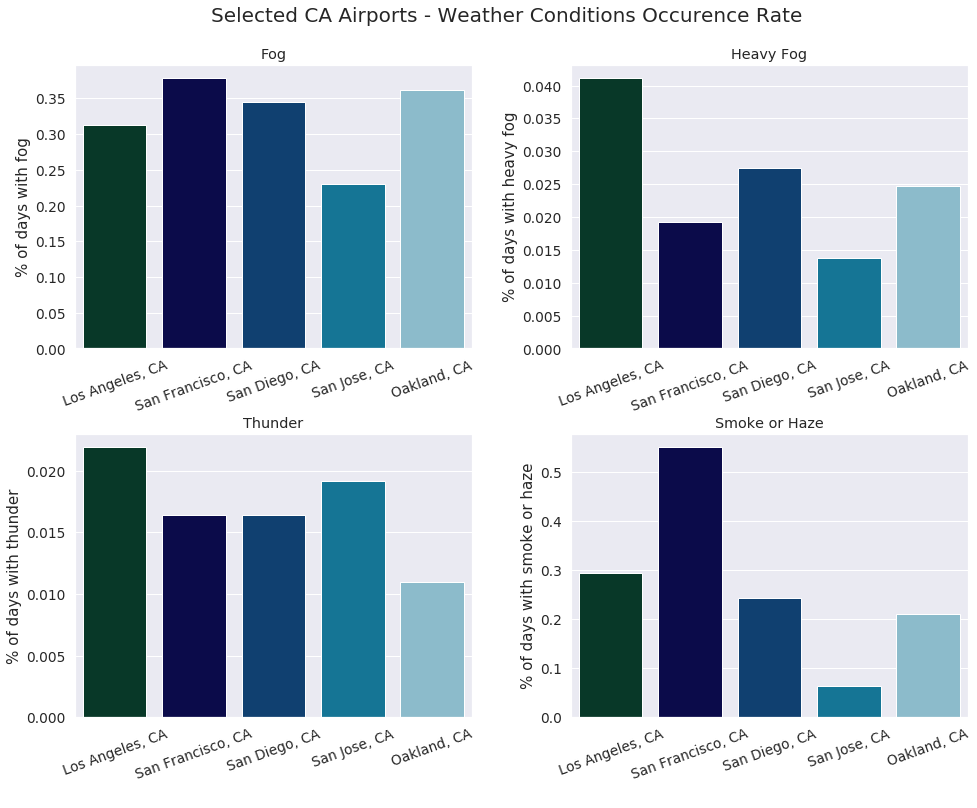

In [355]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
sns.set(font_scale=1.2)

sns.barplot(x='ORIGIN_CITY_NAME',y='fog_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[0,0])
sns.barplot(x='ORIGIN_CITY_NAME',y='heavy_fog_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[0,1])
sns.barplot(x='ORIGIN_CITY_NAME',y='thunder_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[1,0])
sns.barplot(x='ORIGIN_CITY_NAME',y='smoke_haze_rate',data=ca_five_flight_weather_pivot.sort_values('total_flight_year',ascending=False),palette='ocean',ax=axes[1,1])

axes[0,0].set(ylabel="% of days with fog")
axes[0,0].set_title('Fog')
axes[0,0].set_xlabel(' ')
axes[0,1].set(ylabel="% of days with heavy fog")
axes[0,1].set_title('Heavy Fog')
axes[1,0].set(ylabel="% of days with thunder")
axes[1,0].set_title('Thunder')
axes[1,1].set(ylabel="% of days with smoke or haze")
axes[1,1].set_title('Smoke or Haze')
for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')
plt.figtext(.5,.93,'Selected CA Airports - Weather Conditions Occurence Rate', fontsize=20, ha='center')
plt.subplots_adjust(wspace = 0.25, hspace = 0.3)
plt.savefig('../img/weather_CA.png', bbox_inches = "tight")

# More t-test about weather

In [94]:
ca_five_flight_weather

ORIGIN_CITY_NAME    FL_DATE  total_flight  avg_delay_min  \
0     Los Angeles, CA 2019-02-01           605      16.117355   
1     Los Angeles, CA 2019-02-02           468      17.777778   
2     Los Angeles, CA 2019-02-03           537       9.040968   
3     Los Angeles, CA 2019-02-04           597      16.695142   
4     Los Angeles, CA 2019-02-05           552       5.038043   
...               ...        ...           ...            ...   
1819     San Jose, CA 2020-01-27           177      -2.949153   
1820     San Jose, CA 2020-01-28           162      -4.234568   
1821     San Jose, CA 2020-01-29           168      -2.476190   
1822     San Jose, CA 2020-01-30           176       2.971591   
1823     San Jose, CA 2020-01-31           177       3.463277   

      cancelled_count  cancel_rate             city       date  avg_wind_spd  \
0                 7.0     0.011570  Los Angeles, CA 2019-02-01          6.49   
1                 7.0     0.014957  Los Angeles, CA 2019-02-02         11.41   
2                 4.0     0.007449  Los Angeles, CA 2019-02-03          7.83   
3                13.0     0.021776  Los Angeles, CA 2019-02-04         12.30   
4                 6.0     0.010870  Los Angeles, CA 2019-02-05         14.32   
...               ...          ...              ...        ...           ...   
1819              1.0     0.005650     San Jose, CA 2020-01-27          4.03   
1820              5.0     0.030864     San Jose, CA 2020-01-28          4.47   
1821              1.0     0.005952     San Jose, CA 2020-01-29          7.38   
1822              0.0     0.000000     San Jose, CA 2020-01-30          3.36   
1823              3.0     0.016949     San Jose, CA 2020-01-31          2.01   

      precip  avg_temp  fog  heavy_fog  thunder  smoke_haze  
0       0.01      55.0  0.0        0.0      0.0         0.0  
1       1.45      57.0  1.0        0.0      0.0         0.0  
2       0.25      56.0  1.0        0.0      0.0         1.0  
3       0.27      56.0  1.0        0.0      0.0         0.0  
4       0.12      54.0  1.0        0.0      0.0         0.0  
...      ...       ...  ...        ...      ...         ...  
1819    0.00       0.0  0.0        0.0      0.0         0.0  
1820    0.01       0.0  1.0        0.0      0.0         0.0  
1821    0.00       0.0  0.0        0.0      0.0         0.0  
1822    0.00       0.0  1.0        0.0      0.0         0.0  
1823    0.00       0.0  1.0        1.0      0.0         0.0  

[1824 rows x 15 columns]

### LAX weather conditions and cancellation rate

In [360]:
lax_df =  ca_five_flight_weather[ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'Los Angeles, CA']

In [361]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(lax_df,'fog','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

114 251
11.199373330264914 9.242458882119315
0.7046093225360924
2.7773042245624824 0.0030563608959674003


In [362]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(lax_df,'heavy_fog','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

15 350
8.512513364178506 9.911137253141337
1.5632028239633593
-0.8947168387380128 0.8074932878431003


In [363]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(lax_df,'thunder','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

8 357
10.161257633026278 9.846766605036233
2.1144679261582104
0.1487329384851181 0.4429007120443109


In [364]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(lax_df,'smoke_haze','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

107 258
9.010169809638553 10.203478951282255
0.6350120049319489
-1.8791914678393888 0.9691614723958684


### SFO and weather condition

In [365]:
sfo_df =  ca_five_flight_weather[ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'San Francisco, CA']

In [366]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(sfo_df,'fog','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 227
16.67798694165874 11.102852222334388
1.4246622846616341
3.9133026678308407 6.290298213264961e-05


In [367]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(sfo_df,'heavy_fog','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

7 358
21.40148782123951 13.050556529804853
3.512412931910615
2.3775482704683237 0.026148160199895513


In [368]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(sfo_df,'thunder','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

6 359
43.42882753505658 12.70567322342194
7.385401129307606
4.159984511838558 0.004291315517956726


In [369]:
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_quan(sfo_df,'smoke_haze','avg_delay_min')
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

201 164
14.381992181107 11.77517819522138
1.2065631572323254
2.160528415160014 0.015706469058247283


Verify with scipy

In [119]:
a = ca_five_flight_weather[(ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'San Francisco, CA') & (ca_five_flight_weather['fog'] == 1)]['avg_delay_min']
b = ca_five_flight_weather[(ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'San Francisco, CA') & (ca_five_flight_weather['fog'] == 0)]['avg_delay_min']
scs.ttest_ind(a,b,equal_var=False)

Ttest_indResult(statistic=3.9133026678308456, pvalue=0.00012580596426529727)

In [134]:
a = ca_five_flight_weather[(ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'San Francisco, CA') & (ca_five_flight_weather['smoke_haze'] == 1)]['avg_delay_min']
b = ca_five_flight_weather[(ca_five_flight_weather['ORIGIN_CITY_NAME'] == 'San Francisco, CA') & (ca_five_flight_weather['smoke_haze'] == 0)]['avg_delay_min']
scs.ttest_ind(a,b,equal_var=False)

Ttest_indResult(statistic=2.160528415160007, pvalue=0.03141293811649509)

### t-test between cities

In [370]:
city1 = 'San Francisco, CA'
city2 = 'Los Angeles, CA'
condition = 'fog'
cond_flag = 1
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 114
16.67798694165874 11.199373330264914
1.4444944953691103
3.792754924963478 9.903261287700614e-05


In [371]:
city1 = 'San Francisco, CA'
city2 = 'Los Angeles, CA'
condition = 'fog'
cond_flag = 0
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

227 251
11.102852222334388 9.242458882119315
0.6630026965182098
2.806011725118188 0.0026528660177452764


In [372]:
city1 = 'San Francisco, CA'
city2 = 'Oakland, CA'
condition = 'fog'
cond_flag = 1
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 132
16.67798694165874 10.483554853129164
1.5097918812441107
4.1028383881791655 2.864196581039635e-05


In [373]:
city1 = 'San Francisco, CA'
city2 = 'Oakland, CA'
condition = 'fog'
cond_flag = 0
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

227 232
11.102852222334388 8.370759608918156
0.6944841346416992
3.933988520595625 4.96945907246121e-05


In [374]:
city1 = 'San Francisco, CA'
city2 = 'San Jose, CA'
condition = 'fog'
cond_flag = 1
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

138 84
16.67798694165874 7.7394403337954305
1.5797983904915152
5.658029949683835 2.3964890552093214e-08


In [375]:
city1 = 'San Francisco, CA'
city2 = 'San Jose, CA'
condition = 'fog'
cond_flag = 0
col = 'avg_delay_min'
N1, N2, Mean1, Mean2, a_b_std, t_score, p_val = t_test_weather_city(ca_five_flight_weather, city1, city2, condition , cond_flag,col)
print(N1, N2)
print(Mean1, Mean2)
print(a_b_std)
print(t_score, p_val/2)

227 281
11.102852222334388 4.999873325682397
0.6622974411676662
9.214861053807047 1.6605785350427294e-18
